Overview

I did this small project to get some hands on experience on image processing. Here, I analysed a database of lower GI tract endoscopic imaging (https://www.kaggle.com/datasets/heartzhacker/medical-imaging/data). The database is comprised by 4000 images, divided into 4 sets of 1000 images of patientes with one of the following pathologies: diverticulosis, neoplasm, peritonitis or ureters.

Without any significant manual model tuning, we were able to obtain an overall 0.845 accuracy.

# Import Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import PIL
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
import glob
from PIL import Image
import os
from sklearn.metrics import accuracy_score

2024-04-03 11:07:48.594923: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-03 11:07:48.594984: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-03 11:07:48.596484: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_dir = '/kaggle/input/medical-imaging/Medical-imaging-dataset'
image_count = len(glob.glob(data_dir + '/*/*.jpg', recursive=True))
print(image_count)

4000


In [3]:
# define data
batch_size = 32
img_height = 256
img_width = 256

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4000 files belonging to 4 classes.
Using 3200 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4000 files belonging to 4 classes.
Using 800 files for validation.


In [6]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)
print(num_classes)

['Diverticulosis', 'Neoplasm', 'Peritonitis', 'Ureters']
4


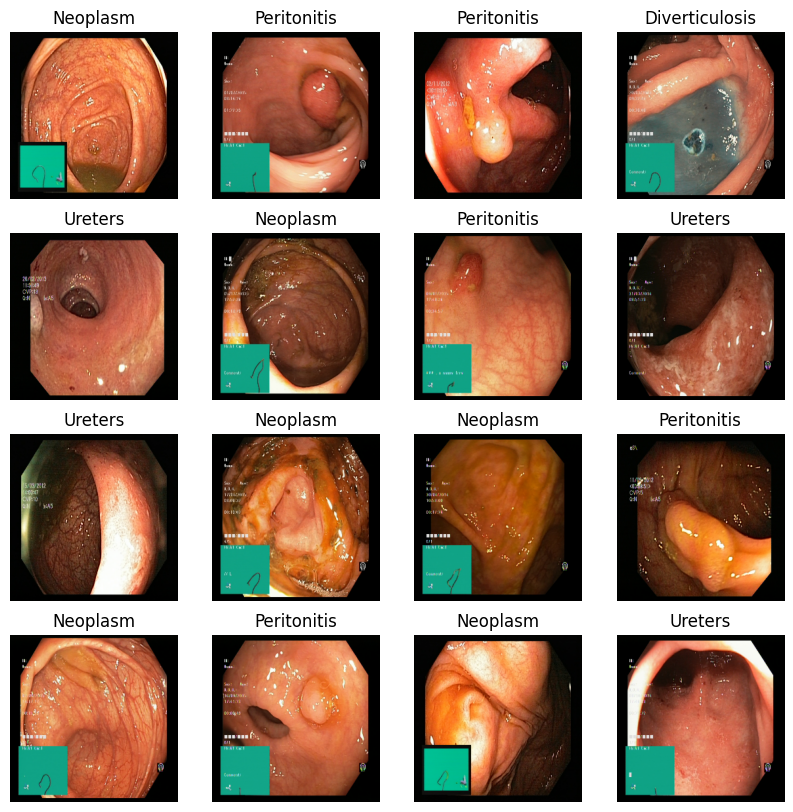

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

#32 batch size
#256 pixel height
#256 pixel width
#3 color channels (RGB)

(32, 256, 256, 3)
(32,)


In [12]:
labels_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([2, 3, 1, 3, 0, 3, 2, 2, 3, 0, 1, 1, 0, 0, 2, 2, 1, 1, 2, 0, 3, 2,
       0, 2, 0, 2, 1, 2, 0, 2, 1, 3], dtype=int32)>

In [13]:
for image_batch, labels_batch in val_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

#32 batch size
#256 pixel height
#256 pixel width
#3 color channels (RGB)

(32, 256, 256, 3)
(32,)


# Configure the dataset for performance

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Data standardization

In [22]:
normalization_layer = layers.Rescaling(1./255)

In [23]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


# Create the model

In [24]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Compile the model

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,412,836 (32.09 MB)

 Trainable params: 8,412,836 (32.09 MB)

 Non-trainable params: 0 (0.00 B)

# Train the model

In [27]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


2024-04-03 11:13:24.633530: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.96116, expected 2.28267
2024-04-03 11:13:24.633584: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.13388, expected 3.45539
2024-04-03 11:13:24.633600: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.32371, expected 3.64522
2024-04-03 11:13:24.633613: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.43312, expected 4.75463
2024-04-03 11:13:24.633624: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.46228, expected 4.78378
2024-04-03 11:13:24.633634: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.69444, expected 5.01594
2024-04-03 11:13:24.633645: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.74803, expected 4.06954
2024-04-03 11:13:24.633655: E external/local_xla/xla/se

  7/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.2353 - loss: 5.3257

I0000 00:00:1712142808.855123    1543 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.5858 - loss: 1.6958 - val_accuracy: 0.7613 - val_loss: 0.5783
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7702 - loss: 0.5546 - val_accuracy: 0.7287 - val_loss: 0.5781
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7922 - loss: 0.4997 - val_accuracy: 0.7812 - val_loss: 0.5532
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8115 - loss: 0.4527 - val_accuracy: 0.7337 - val_loss: 0.6009
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8345 - loss: 0.4127 - val_accuracy: 0.7837 - val_loss: 0.5719
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8585 - loss: 0.3790 - val_accuracy: 0.7500 - val_loss: 0.6112
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8919 - loss: 0.2899 - val_accuracy: 0.7788 - val_loss: 0.5378
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9083 - loss: 0.2436 - val_accuracy: 0.78

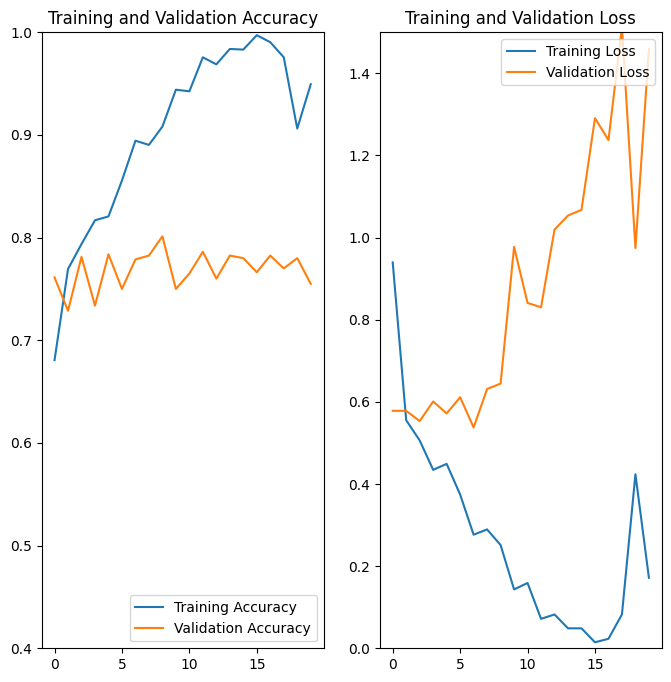

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.ylim(0.4, 1)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.ylim(0, 1.5)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Data augmentation

In [29]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

# Dropout

In [30]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [33]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


2024-04-03 11:14:23.103231: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_2_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.5430 - loss: 0.9723 - val_accuracy: 0.7200 - val_loss: 0.7102
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.7361 - loss: 0.6068 - val_accuracy: 0.7700 - val_loss: 0.5054
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.7674 - loss: 0.5608 - val_accuracy: 0.7575 - val_loss: 0.5500
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.7689 - loss: 0.5161 - val_accuracy: 0.7950 - val_loss: 0.4657
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.7959 - loss: 0.4821 - val_accuracy: 0.7550 - val_loss: 0.5167
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.8116 - loss: 0.4475 - val_accuracy: 0.8012 - val_loss: 0.4474
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.8176 - loss: 0.4404 - val_accuracy: 0.8062 - val_loss: 0.4434
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.8342 - loss: 0.4072 - val_accuracy: 0.755

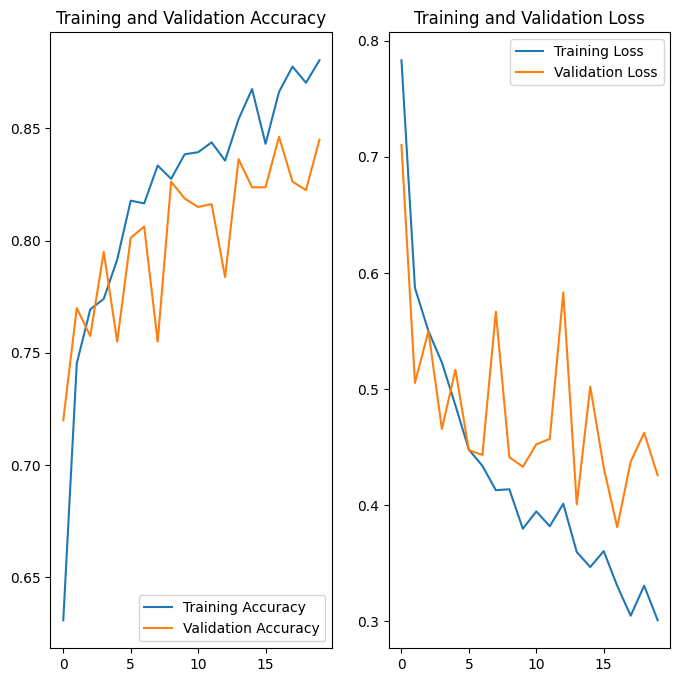

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [35]:
predictions = model.predict(val_ds)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [39]:
y_pred = np.argmax(predictions, axis=1)

In [40]:
y_pred.shape

(800,)

In [51]:
# Initialize an empty list to store all labels
true_labels = []

# Iterate through the entire validation dataset
for image_batch, labels_batch in val_ds:
    # Concatenate labels from the current batch to the list of all labels
    true_labels.append(labels_batch)

# Concatenate the list of labels into a single numpy array
all_labels = np.concatenate(true_labels, axis=0)

# Now all_labels will contain all labels of the validation dataset
print(all_labels.shape)

(800,)


In [52]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(all_labels, y_pred)

In [53]:
print(conf_matrix)

[[182   1   2   0]
 [  0 185  10   6]
 [  0  17 120  54]
 [  0   1  33 189]]


In [54]:
accuracy_score(all_labels, y_pred)

0.845

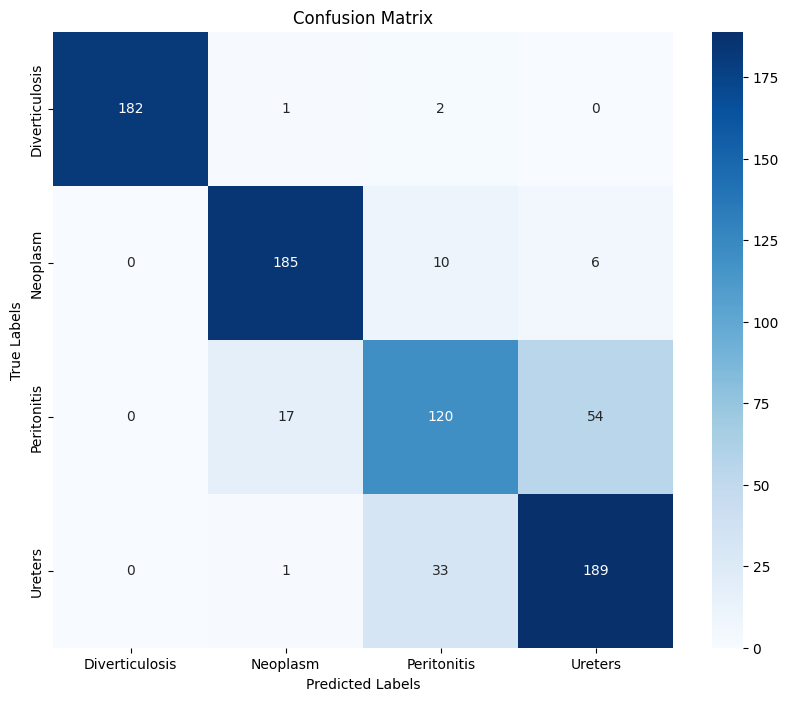

In [58]:
import seaborn as sns
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()